## In this code we use the LSTM model to assess a data set with only the returns that occure in each percentile. We had hopped this could lead us to tomorrows market direction but it did not work well

In [86]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import History 
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import pandas_datareader.data as web
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols

In [87]:
from google.colab import files
uploaded = files.upload()

Saving dataframe2.csv to dataframe2 (1).csv


### Reading in the data

In [185]:
df = pd.read_csv('dataframe2.csv')

In [186]:
df.columns

Index(['date', 'LOW_x', 'HIGH_x', 'PRICE_x', 'CLOSINGBID_x', 'CLOSEINGASK_x',
       'VOL_x', 'LOW_y', 'HIGH_y', 'PRICE_y', 'CLOSINGBID_y', 'CLOSEINGASK_y',
       'VOL_y', 'dailyreturns', 'totalcap', 'chngcap', 'divfac', 'spread',
       'shrout', 'SDT_RET', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF',
       'SPYRET', 'TMW_SPYRET', 'UP_DWN', 'X5', 'X10', 'X15', 'X20', 'X25',
       'X30', 'X35', 'X40', 'X45', 'X50', 'X55', 'X60', 'X65', 'X70', 'X75',
       'X80', 'X85', 'X90', 'X95', 'SINTMWSPYRET'],
      dtype='object')

We only look at the dates from 2011 to end of 2021

In [187]:
df1 = df[df['date']>= '2010-12-31']

In [188]:
df1 = df1.reset_index(drop=True)

In [189]:
df1

,date,LOW_x,HIGH_x,PRICE_x,CLOSINGBID_x,CLOSEINGASK_x,VOL_x,LOW_y,HIGH_y,PRICE_y,CLOSINGBID_y,CLOSEINGASK_y,VOL_y,dailyreturns,totalcap,chngcap,divfac,spread,shrout,SDT_RET,Mkt-RF,SMB,HML,RMW,CMA,RF,SPYRET,TMW_SPYRET,UP_DWN,X5,X10,X15,X20,X25,X30,X35,X40,X45,X50,X55,X60,X65,X70,X75,X80,X85,X90,X95,SINTMWSPYRET
0,2010-12-31,125.33000,125.87000,125.75000,125.79000,125.80000,91270200.0,125.33000,125.87000,125.75000,125.79000,125.80000,91270200.0,0.001509,8.150828e+09,0.000252,0.000085,17.314055,2116958.57,0.005491,-0.10,-0.61,0.23,-0.14,0.13,0.001,0.000239,0.010338,1.0,-0.006599,-0.004761,-0.003457,-0.002819,-0.001951,-0.001029,0.000000,0.000533,0.000790,0.000994,0.001513,0.002334,0.003289,0.004151,0.004768,0.005788,0.006382,0.007681,0.011042,0.859249
1,2011-01-03,125.69690,127.60000,127.05000,127.04000,127.05000,138725200.0,125.69690,127.60000,127.05000,127.04000,127.05000,138725200.0,0.009917,8.239130e+09,0.010834,0.000043,5.906452,2116958.57,0.011948,1.18,0.56,0.78,-0.42,0.17,0.000,0.010338,-0.000551,0.0,-0.007274,-0.001971,-0.000618,0.001171,0.002882,0.005026,0.005998,0.006840,0.007517,0.008516,0.009601,0.010204,0.011140,0.013149,0.015322,0.017614,0.020429,0.023858,0.029152,-0.055072
2,2011-01-04,126.19000,127.37000,126.98000,126.92000,126.93000,137409700.0,126.19000,127.37000,126.98000,126.92000,126.93000,137409700.0,-0.000961,8.244332e+09,0.000631,0.000093,10.389852,2116958.57,0.012038,-0.26,-1.33,0.06,0.02,0.04,0.000,-0.000551,0.005198,1.0,-0.021888,-0.018236,-0.012909,-0.007515,-0.006708,-0.005725,-0.004847,-0.003316,-0.002328,-0.001381,-0.000135,0.001237,0.002874,0.003867,0.004913,0.008185,0.009195,0.015914,0.020077,0.496707
3,2011-01-05,126.46000,127.72500,127.64000,127.62000,127.63000,133975200.0,126.46000,127.72500,127.64000,127.62000,127.63000,133975200.0,0.005421,8.279884e+09,0.004312,0.000267,17.485266,2113947.42,0.013267,0.59,0.61,0.14,-0.42,0.07,0.000,0.005198,-0.001959,0.0,-0.010557,-0.006629,-0.004169,-0.003196,-0.002530,-0.001546,-0.000123,0.001572,0.002419,0.003851,0.005075,0.006469,0.008342,0.009980,0.012268,0.013102,0.014347,0.020827,0.025222,-0.194649
4,2011-01-06,127.01000,127.83000,127.39000,127.39000,127.39000,122519000.0,127.01000,127.83000,127.39000,127.39000,127.39000,122519000.0,-0.003446,8.257190e+09,-0.002741,0.000273,9.410691,2113947.42,0.014661,-0.15,-0.13,-0.34,-0.12,-0.07,0.000,-0.001959,-0.001962,0.0,-0.025452,-0.019781,-0.013334,-0.010705,-0.009022,-0.008254,-0.007804,-0.006339,-0.005771,-0.004594,-0.004022,-0.002113,-0.001030,0.000248,0.003200,0.004965,0.010349,0.015021,0.020803,-0.194944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2020-12-24,367.45001,369.03000,369.00000,368.97000,368.98999,26457853.0,367.45001,369.03000,369.00000,368.97000,368.98999,26457853.0,0.001969,2.401165e+10,0.002334,0.000104,44.291331,1748881.13,0.016186,0.21,-0.43,-0.18,0.23,-0.06,0.000,0.003890,0.008591,1.0,-0.010462,-0.005240,-0.003967,-0.002976,-0.002048,-0.001032,-0.000298,0.001381,0.002521,0.003425,0.003819,0.004234,0.004842,0.006083,0.006912,0.007937,0.010267,0.011410,0.016761,0.757255
2514,2020-12-28,371.07001,372.59000,372.17001,372.13000,372.14001,39000402.0,371.07001,372.59000,372.17001,372.13000,372.14001,39000402.0,0.004419,2.428004e+10,0.011177,0.000000,45.152603,1762696.99,0.012615,0.46,-0.67,0.34,1.39,0.46,0.000,0.008591,-0.001908,0.0,-0.012080,-0.006379,-0.004905,-0.002554,-0.000983,-0.000520,0.000843,0.001668,0.002964,0.004482,0.005807,0.006430,0.007072,0.008633,0.009715,0.011287,0.013402,0.017880,0.023810,-0.189644
2515,2020-12-29,370.82999,374.00000,371.45999,371.47000,371.47000,53680451.0,370.82999,374.00000,371.45999,371.47000,371.47000,53680451.0,0.001078,2.427635e+10,-0.000152,0.000000,33.126933,1768217.95,0.011280,-0.40,-1.42,0.23,0.75,-0.30,0.000,-0.001908,0.001427,1.0,-0.010727,-0.009144,-0.007525,-0.006383,-0.006050,-0.005001,-0

Only pulling the variabels that we want in this case just the percentile columns and the price of x

In [190]:
df1 = df1.drop(columns= ['LOW_x', 'HIGH_x', 'CLOSEINGASK_y','CLOSINGBID_x', 'CLOSEINGASK_x','VOL_x','LOW_y','HIGH_y','PRICE_y','CLOSINGBID_y','VOL_y','SPYRET','TMW_SPYRET','UP_DWN','Mkt-RF','SINTMWSPYRET','dailyreturns', 'totalcap', 'chngcap', 'divfac', 'spread','shrout', 'SDT_RET', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF','SPYRET', 'TMW_SPYRET'])

In [191]:
df1 = df1.head(2516)

In [192]:
df1.tail()

,date,PRICE_x,X5,X10,X15,X20,X25,X30,X35,X40,X45,X50,X55,X60,X65,X70,X75,X80,X85,X90,X95
2511,2020-12-22,367.23999,-0.021060,-0.019881,-0.016954,-0.014690,-0.011525,-0.009167,-0.008129,-0.007445,-0.006182,-0.004166,-0.003215,-0.002301,-0.001587,0.000311,0.001718,0.003272,0.006631,0.011996,0.024482
2512,2020-12-23,367.57001,-0.020284,-0.014889,-0.011305,-0.007865,-0.006982,-0.005381,-0.004633,-0.001616,-0.000442,0.000636,0.001976,0.003955,0.004661,0.007990,0.010022,0.011866,0.014631,0.019243,0.023656
2513,2020-12-24,369.00000,-0.010462,-0.005240,-0.003967,-0.002976,-0.002048,-0.001032,-0.000298,0.001381,0.002521,0.003425,0.003819,0.004234,0.004842,0.006083,0.006912,0.007937,0.010267,0.011410,0.016761
2514,2020-12-28,372.17001,-0.012080,-0.006379,-0.004905,-0.002554,-0.000983,-0.000520,0.000843,0.001668,0.002964,0.004482,0.005807,0.006430,0.007072,0.008633,0.009715,0.011287,0.013402,0.017880,0.023810
2515,2020-12-29,371.45999,-0.010727,-0.009144,-0.007525,-0.006383,-0.006050,-0.005001,-0.003902,-0.002754,-0.002111,-0.001827,0.000024,0.001805,0.003594,0.004519,0.005253,0.006338,0.007910,0.011631,0.020131


In [193]:
train_size = round(0.7*len(df1))

In [194]:
training_set = df1.iloc[:train_size, 1:].values
test_set =df1.iloc[train_size:, 1:].values

Scaling the price data to be between 0 and 1

In [195]:
sc = MinMaxScaler(feature_range = (0, 1))
x_training_set_scaled = (training_set[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]])
y_training_set_scaled = sc.fit_transform(pd.DataFrame(training_set[:,0]))

This creates a function that will loop through 30 rolling days to predict the thirty first day this will be our prediction function

In [196]:
X_train = []
y_train = []
for i in range(30, train_size):
    X_train.append(x_training_set_scaled[i-30:i,:])
    y_train.append(y_training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 19))

this does the same as above but for the testing data

In [197]:
x_test_set_scaled = (test_set[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]])
y_test_set_scaled = sc.fit_transform(pd.DataFrame(test_set[:,0]))
X_test = []
y_test = []
for i in range(30, (len(df1) - train_size)):
    X_test.append(x_test_set_scaled[i-30:i,:])
    y_test.append(y_test_set_scaled[i,:])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 19))

In [200]:
epochs = 100

Creating and training 4 LSTM layers.

In [201]:
#def lstm(x_train,y_train,x_test,y_test,epochs):
history = History()
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 19)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = epochs, batch_size = 20,callbacks=[history])

predicted_stock_price = model.predict(X_test)

mse = mean_squared_error(y_test,predicted_stock_price)
loss = history.history['loss']

#return mse
print(loss)

Epoch 1/100
87/87 [==============================] - 12s 62ms/step - loss: 0.0773
Epoch 2/100
87/87 [==============================] - 5s 61ms/step - loss: 0.0606
Epoch 3/100
87/87 [==============================] - 5s 61ms/step - loss: 0.0505
Epoch 4/100
87/87 [==============================] - 5s 60ms/step - loss: 0.0497
Epoch 5/100
87/87 [==============================] - 5s 60ms/step - loss: 0.0462
Epoch 6/100
87/87 [==============================] - 5s 60ms/step - loss: 0.0480
Epoch 7/100
87/87 [==============================] - 5s 59ms/step - loss: 0.0461
Epoch 8/100
87/87 [==============================] - 5s 60ms/step - loss: 0.0446
Epoch 9/100
87/87 [==============================] - 5s 61ms/step - loss: 0.0437
Epoch 10/100
87/87 [==============================] - 5s 60ms/step - loss: 0.0427
Epoch 11/100
87/87 [==============================] - 5s 61ms/step - loss: 0.0426
Epoch 12/100
87/87 [==============================] - 5s 60ms/step - loss: 0.0446
Epoch 13/100
87/87 [====

### As you can see this preforms much worse than any other model 100 epochs than the simpler model from 'Simpledata_LSTM'.

### When we ran through 100 epochs we got better loss numbers but we got worst R^2 on the regression below

### it also functioned worse as a guide for our portfolio

Both of these cells convert the functions back to the pre scaled functions

In [202]:
predicted_stock_price = model.predict(X_test)

In [203]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [204]:
y_test = sc.inverse_transform(y_test)

Plotting the outcome of the predictions vs the actuals

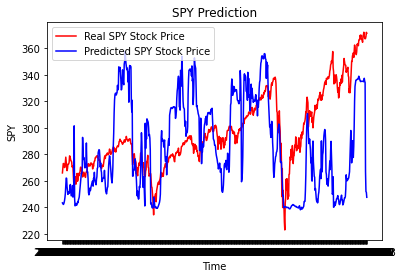

In [205]:
# Visualising the results
plt.plot(df1.loc[train_size:len(df1)-31, 'date'],y_test, color = 'red', label = 'Real SPY Stock Price')
plt.plot(df1.loc[train_size:len(df1)-31, 'date'],predicted_stock_price, color = 'blue', label = 'Predicted SPY Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('SPY Prediction')
plt.xlabel('Time')
plt.ylabel('SPY')
plt.legend()
plt.show()

In [206]:
regression = pd.DataFrame(y_test)
regression['predict'] = predicted_stock_price

In [207]:
regression.columns = ['real','predict']

We run this regression to check and see how the model works in explaining the actual stock pric

In [208]:
regression

,real,predict
0,266.00000,243.375381
1,269.59000,243.035355
2,273.03000,242.165070
3,273.10999,242.497742
4,271.39999,243.526047
...,...,...
720,367.23999,334.273224
721,367.57001,267.087585
722,369.00000,251.943787
723,372.17001,251.370621


In [209]:
model = ols('predict ~ real',regression).fit()

In [210]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                predict   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     60.08
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           3.10e-14
Time:                        19:59:49   Log-Likelihood:                -3580.4
No. Observations:                 725   AIC:                             7165.
Df Residuals:                     723   BIC:                             7174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    185.9935     13.005     14.302      0.000     160.462     211.525
real           0.3388      0.044      7.751      0.000       0.253       0.425
==============================================================================
Omnibus:                      221.284   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.769
Skew:                           0.230   Prob(JB):                     1.40e-09
Kurtosis:                       1.933   Cond. No.                     3.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Through all of these results you can see that this model does not do well in predicting the market. It also onlt explains about 7.7 percent of the volititlity. 